<a href="https://colab.research.google.com/github/hiddouche/NLP/blob/master/translation_with_RNN_deutchToEnglish___copyFromColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Required Libraries

In [1]:
import sys
import os
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
import urllib.request
data_path = os.path.join("datasets", "")
filename = "deu.txt"
URL = "https://docs.google.com/uc?export=download&id=1LYw_wl5ftE4ejhFPFpfar4lt1HvNKZgN"
 
os.makedirs(data_path, exist_ok=True)
 
print("Downloading deu.txt")

urllib.request.urlretrieve(URL, data_path + filename)


('datasets/deu.txt', <http.client.HTTPMessage at 0x7fd0b0a50f98>)

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [5]:


 
data = read_text(os.path.join("datasets", "")+"deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [6]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['They come from Sweden.', 'Sie kommen aus Schweden.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #622193 (CK) & #622244 (BraveSentry)'],
       ['They could hardly see.', 'Sie konnten kaum etwas sehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #306021 (CK) & #611800 (virgil)'],
       ["They didn't choose me.", 'Sie wählten mich nicht.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5090802 (AlanF_US) & #5091265 (bonny37)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [9]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['They come from Sweden', 'Sie kommen aus Schweden',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #622193 (CK) & #622244 (BraveSentry)'],
       ['They could hardly see', 'Sie konnten kaum etwas sehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #306021 (CK) & #611800 (virgil)'],
       ['They didnt choose me', 'Sie wählten mich nicht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5090802 (AlanF_US) & #5091265 (bonny37)']],
      dtype='<U537')

In [10]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [11]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['they come from sweden', 'sie kommen aus schweden',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #622193 (CK) & #622244 (BraveSentry)'],
       ['they could hardly see', 'sie konnten kaum etwas sehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #306021 (CK) & #611800 (virgil)'],
       ['they didnt choose me', 'sie wählten mich nicht',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5090802 (AlanF_US) & #5091265 (bonny37)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [12]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

In [14]:
length_df

,eng,deu
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1
...,...,...
49995,5,7
49996,4,5
49997,4,4
49998,4,5


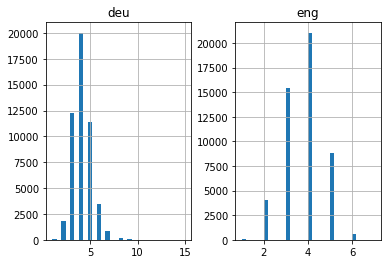

In [15]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6295


In [18]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10401


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    print("-----------------------")
    print(seq)
    print("-----------------------")
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

-----------------------
[[52, 3602, 42, 1054], [2, 3869, 17, 2008], [10, 9, 25, 352, 303], [1, 69, 5, 157], [4, 19, 13, 1362], [10, 3, 67, 1031], [7, 3, 114, 13, 690], [11, 149, 433, 43], [151, 2, 14, 72, 3, 121, 2478], [11, 64, 6, 355], [2, 725, 28, 36, 2534], [1364, 50, 36, 6952], [1079, 86], [1, 115, 13, 534], [2, 1476, 877], [1, 12, 70, 3775], [2, 725, 28, 23, 42, 741], [30, 41, 8, 18, 1832], [21, 81, 38, 953], [1, 62, 39, 575, 1682], [10, 3, 43, 301], [1, 849, 34, 4004], [1, 197, 4, 536], [1, 456, 40, 17, 502], [121, 8773, 3, 8774], [1218, 52, 383, 60], [292, 672, 102], [1, 2100, 18, 6], [1, 12, 282, 2007], [11, 19, 48, 73, 13, 2593], [318, 1, 637, 37], [10, 2624, 25, 9989, 403], [2, 446, 44, 42, 2090], [54, 3, 327, 425], [10, 208, 615], [2, 3, 6, 3760], [1, 24, 747], [11, 435, 57], [2, 20, 834], [8, 3068, 190], [33, 8, 39, 963], [417, 11, 2, 6, 97], [2, 217, 137], [2, 767], [2, 179, 6, 1182], [198, 23, 14, 1665], [113, 125, 178, 23], [1, 347, 98, 910], [15, 1, 55, 112, 586], [26,

In [22]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

-----------------------
[[7, 24, 6, 313, 1393], [2558, 1, 591], [1351, 54, 1, 15], [11, 19, 36, 32, 581], [2, 24, 171, 5549, 392], [1, 45, 58, 57, 9296], [24, 1, 31, 2904], [662, 4, 5, 52, 44], [5, 272, 3, 260], [4, 3211, 28, 89], [1016, 17, 178, 143], [7, 3, 396], [1, 252, 11, 355], [1, 24, 109, 79], [5, 24, 276], [4, 19, 1272], [3, 5, 138, 1058], [1221, 19, 2141], [1, 12, 131, 121, 152], [1, 53, 3779], [4, 19, 285], [165, 4, 28, 6, 2193], [1, 15, 17, 523, 393, 7412], [5, 3, 39, 4995], [1, 12, 84, 1464, 5566], [11, 5265, 192], [16, 226, 5, 6], [1, 20, 56, 691], [2, 9, 34, 299, 200], [5, 62, 74], [8, 41, 13, 325], [41, 8, 57, 612], [22, 329, 795], [1, 20, 111, 114, 2604], [54, 15, 1], [1, 123, 244, 1092, 50], [1, 12, 4964], [2, 9, 5, 152], [1, 69, 6, 50], [56, 228, 1, 5], [21, 1968], [7, 3, 14, 218], [10, 639, 17, 412, 678], [11, 26, 304, 1383], [2, 261, 5], [2, 640, 209, 312], [1, 115, 109, 472], [5, 3, 13, 1761, 1930], [150, 125, 1279, 678], [1, 179, 174, 958, 1414], [59, 473, 21], [

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [23]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [24]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [25]:
filename = 'model.h1.11_07_2020'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 328s 10ms/step - loss: 3.4274 - val_loss: 2.8573

Epoch 00001: val_loss improved from inf to 2.85733, saving model to model.h1.11_07_2020
Epoch 2/30
32000/32000 [==============================] - 327s 10ms/step - loss: 2.7948 - val_loss: 2.7974

Epoch 00002: val_loss improved from 2.85733 to 2.79737, saving model to model.h1.11_07_2020
Epoch 3/30
32000/32000 [==============================] - 312s 10ms/step - loss: 2.6261 - val_loss: 2.5799

Epoch 00003: val_loss improved from 2.79737 to 2.57994, saving model to model.h1.11_07_2020
Epoch 4/30
32000/32000 [==============================] - 325s 10ms/step - loss: 2.4375 - val_loss: 2.4771

Epoch 00004: val_loss improved from 2.57994 to 2.47705, saving model to model.h1.11_07_2020
Epoch 5/30
32000/32000 [==============================] - 316s 10ms/step - loss: 2.2957 - val_loss: 2.3627

Epoch 00005: val_loss improved from 2.47705 to 

Let's compare the training loss and the validation loss.

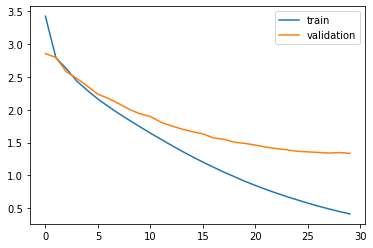

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [27]:
model = load_model('model.h1.11_07_2020')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [28]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [29]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [30]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [31]:
pd.set_option('display.max_colwidth', 200)

In [32]:
pred_df.head(15)

,actual,predicted
0,it cannot last long,it cant take a
1,am i right,i am satisfied
2,guess who i am,what am i am
3,were in town,were on the
4,tom runs the fastest,tom wants an apple
5,i will vouch for him,ill take for him
6,can i spend the night,can i spend the
7,please write it down,please do to
8,the water is hot,the soup is hot
9,they always complain,you always confused


In [33]:
pred_df.tail(15)

,actual,predicted
9985,tom is doing that,tom does that
9986,follow behind me,write me
9987,ill take tom home,ill take tom home
9988,are you on facebook,are you on facebook
9989,is your family ok,is your here
9990,we never help tom,we never help tom
9991,is someone there,is anybody there
9992,are we done,are we done
9993,tom is quite stupid,tom is stupid
9994,that isnt fair,thats not fair


In [34]:
pred_df.sample(15)

,actual,predicted
4572,youre not one of us,you are one of us
8882,i still cant dance,i cant talk yet
4842,who is this girl,whos is girl
2081,give me another one,give me another one
6283,contact tom,contact tom
735,i often catch colds,i have a cold
7006,id like to pay,i want to read
951,its my job,its my job
6505,tom left at midnight,tom went of
70,im a truck driver,im a gym
